In [1]:
import sys
sys.path.append('..')

In [2]:
from spinesTS.data import *
series_data = BuiltInSeriesData(print_file_list=True)
data = series_data['ETTh1']  # series_data[0], it works, too
print(type(data))

+----+----------------------+----------------------------------------------------------------------+
|    | ds name              | columns                                                              |
+----+----------------------+----------------------------------------------------------------------+
|  0 | AirPassengers        | Month, #Passengers                                                   |
|  1 | ETTh1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  2 | ETTh2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  3 | ETTm1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  4 | ETTm2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  5 | Electric_Production  | date, value                                                          |
|  6 | M3_monthly_FTS       | series_id, method_id, forecast, horizon, timestamp, origin_ti

In [3]:
y_name = 'OT'

# Use differencing to improve your predictions

Using the difference method, the trend term in the time series is removed, and the future trend can be predicted more accurately

## The case which the difference method is not used

In [4]:
from spinesTS.ml_model import GBRTPreprocessing, WideGBRT
from lightgbm import LGBMRegressor
from spinesTS.plotting import *
from spinesTS.metrics import *
from sklearn.preprocessing import StandardScaler
from spinesTS.preprocessing import split_series
from spinesTS.ml_model import MultiOutputRegressor
from spinesTS.nn import *

r2: -8.836532060077552
mae: 2.2429005623192206
mape: 154380206337707.28


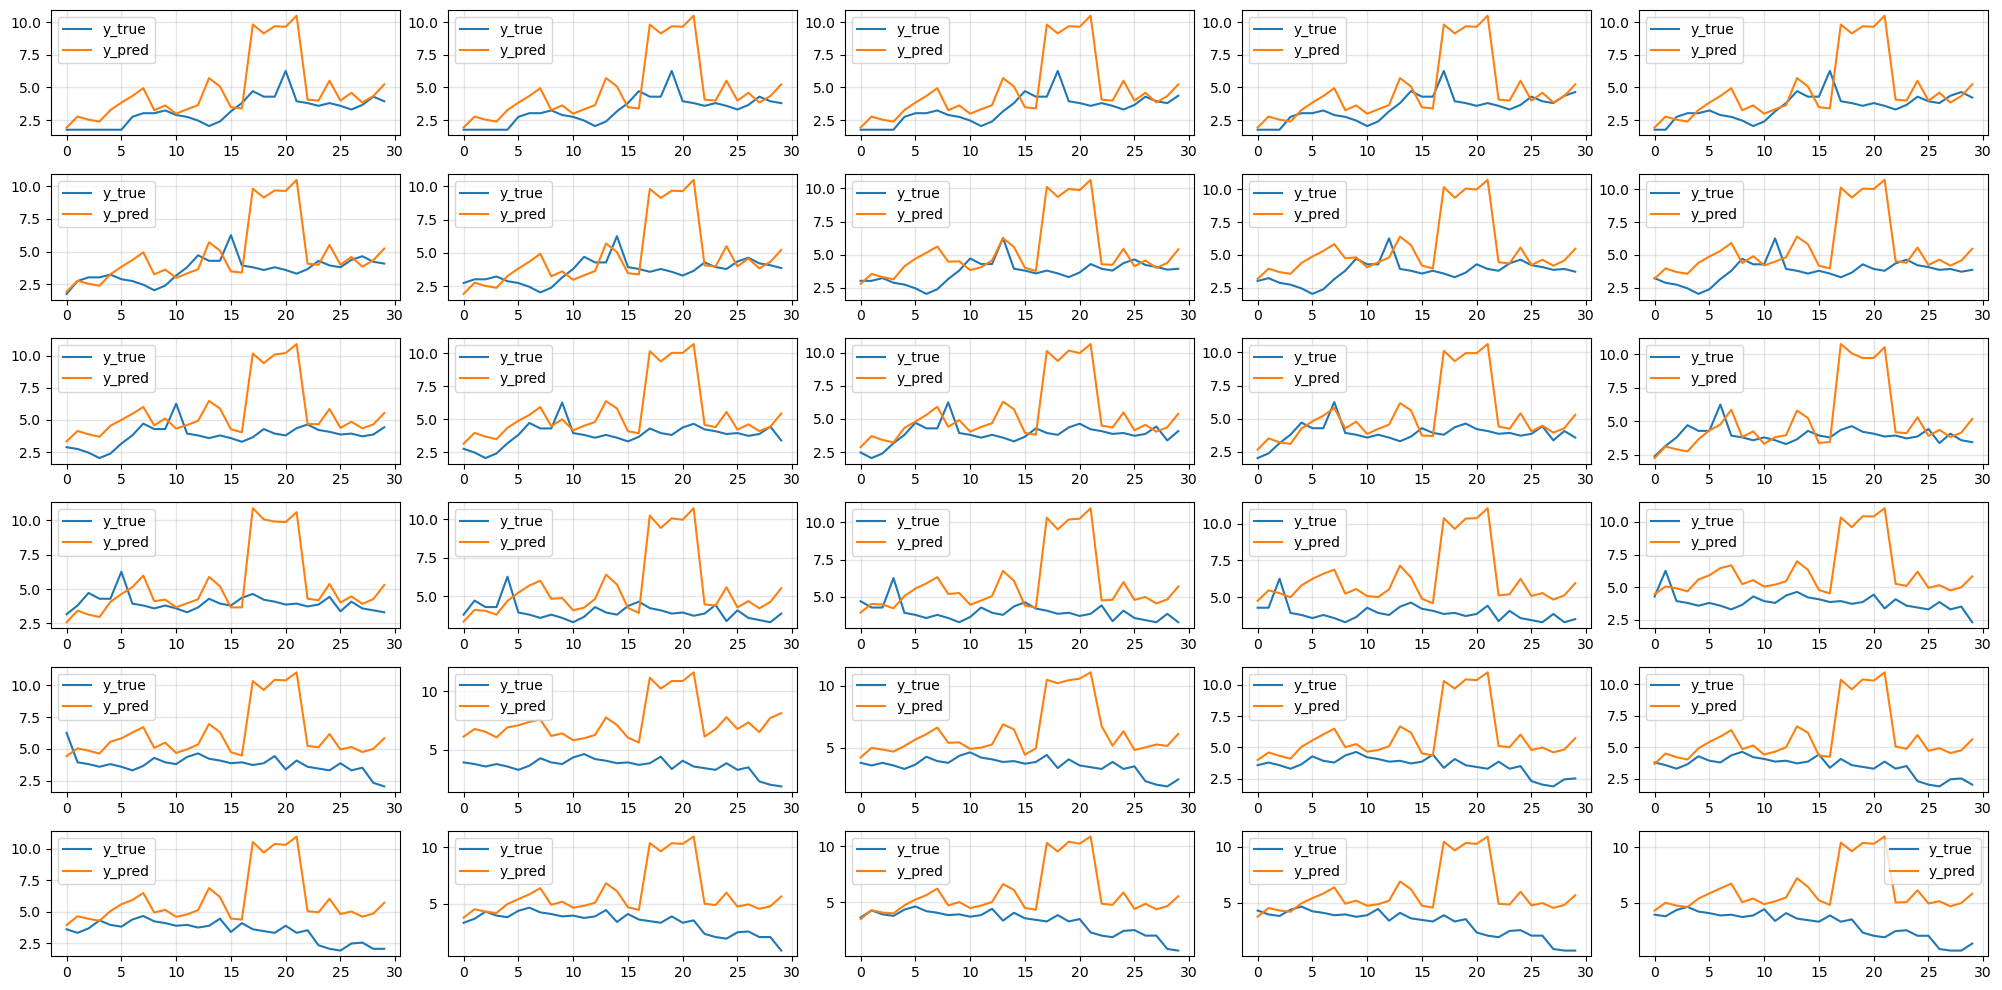

In [5]:
gbrt_processor = GBRTPreprocessing(10, 30, y_name, date_col='date', differential_n=0)
gbrt_processor.fit(data[['date', y_name]])
x_train, x_test, y_train, y_test = gbrt_processor.transform(data[['date', y_name]])

wide_gbrt = WideGBRT(model=LGBMRegressor(linear_tree=True))
wide_gbrt.fit(x_train, y_train, eval_set=([x_test, y_test]), early_stopping_rounds=10, verbose=0)
y_pred = wide_gbrt.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred)}")
a = plot2d(y_test, y_pred, figsize=(20, 10), eval_slices='[:30]', labels=['y_true', 'y_pred'])

In [15]:
import torch
from torch import nn

class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4
        hour_size = 24
        weekday_size = 7
        day_size = 32
        month_size = 13

        Embed = nn.Embedding
        if freq == 't':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()
        if x.ndim == 2:
            x = torch.unsqueeze(x, dim=-1)

        minute_x = self.minute_embed(x[:, :, 4]) if hasattr(self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:, :, 3])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])

        return hour_x + weekday_x + day_x + month_x + minute_x

In [19]:
model = TemporalEmbedding(24)
model(torch.randn(100, 200, 100))

IndexError: index out of range in self

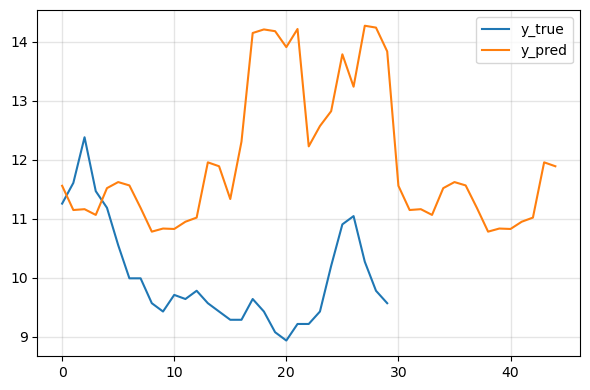

In [13]:
y_pred = wide_gbrt.partial_predict(x_test[-1, :].reshape((1, -1)), 45)
a = plot2d(y_test, y_pred, figsize=(6, 4), eval_slices='[-1]', labels=['y_true', 'y_pred'])

array([[11.55810755, 11.1471828 , 11.16136196, 11.06419517, 11.51802112,
        11.6210399 , 11.56430565, 11.18359176, 10.78049074, 10.83302691,
        10.82582832, 10.94857401, 11.01855689, 11.95563468, 11.88930552,
        11.33362983, 12.30668785, 14.14889952, 14.20933823, 14.17970584,
        13.90951751, 14.21678999, 12.22670323, 12.57094003, 12.82320744,
        13.78737294, 13.23827967, 14.27198101, 14.2404299 , 13.83668665,
        11.55810755, 11.1471828 , 11.16136196, 11.06419517, 11.51802112,
        11.6210399 , 11.56430565, 11.18359176, 10.78049074, 10.83302691,
        10.82582832, 10.94857401, 11.01855689, 11.95563468, 11.88930552]])

## Difference method

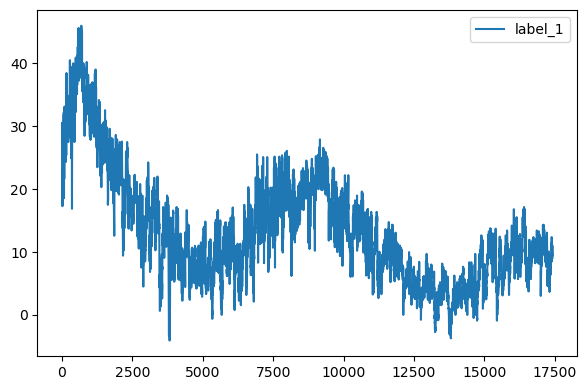

In [7]:
a = plot1d(data['OT'], figsize=(6, 4))

r2: -2.0179631966227407
mae: 1.4418626059898958
mape: 97113679048856.19


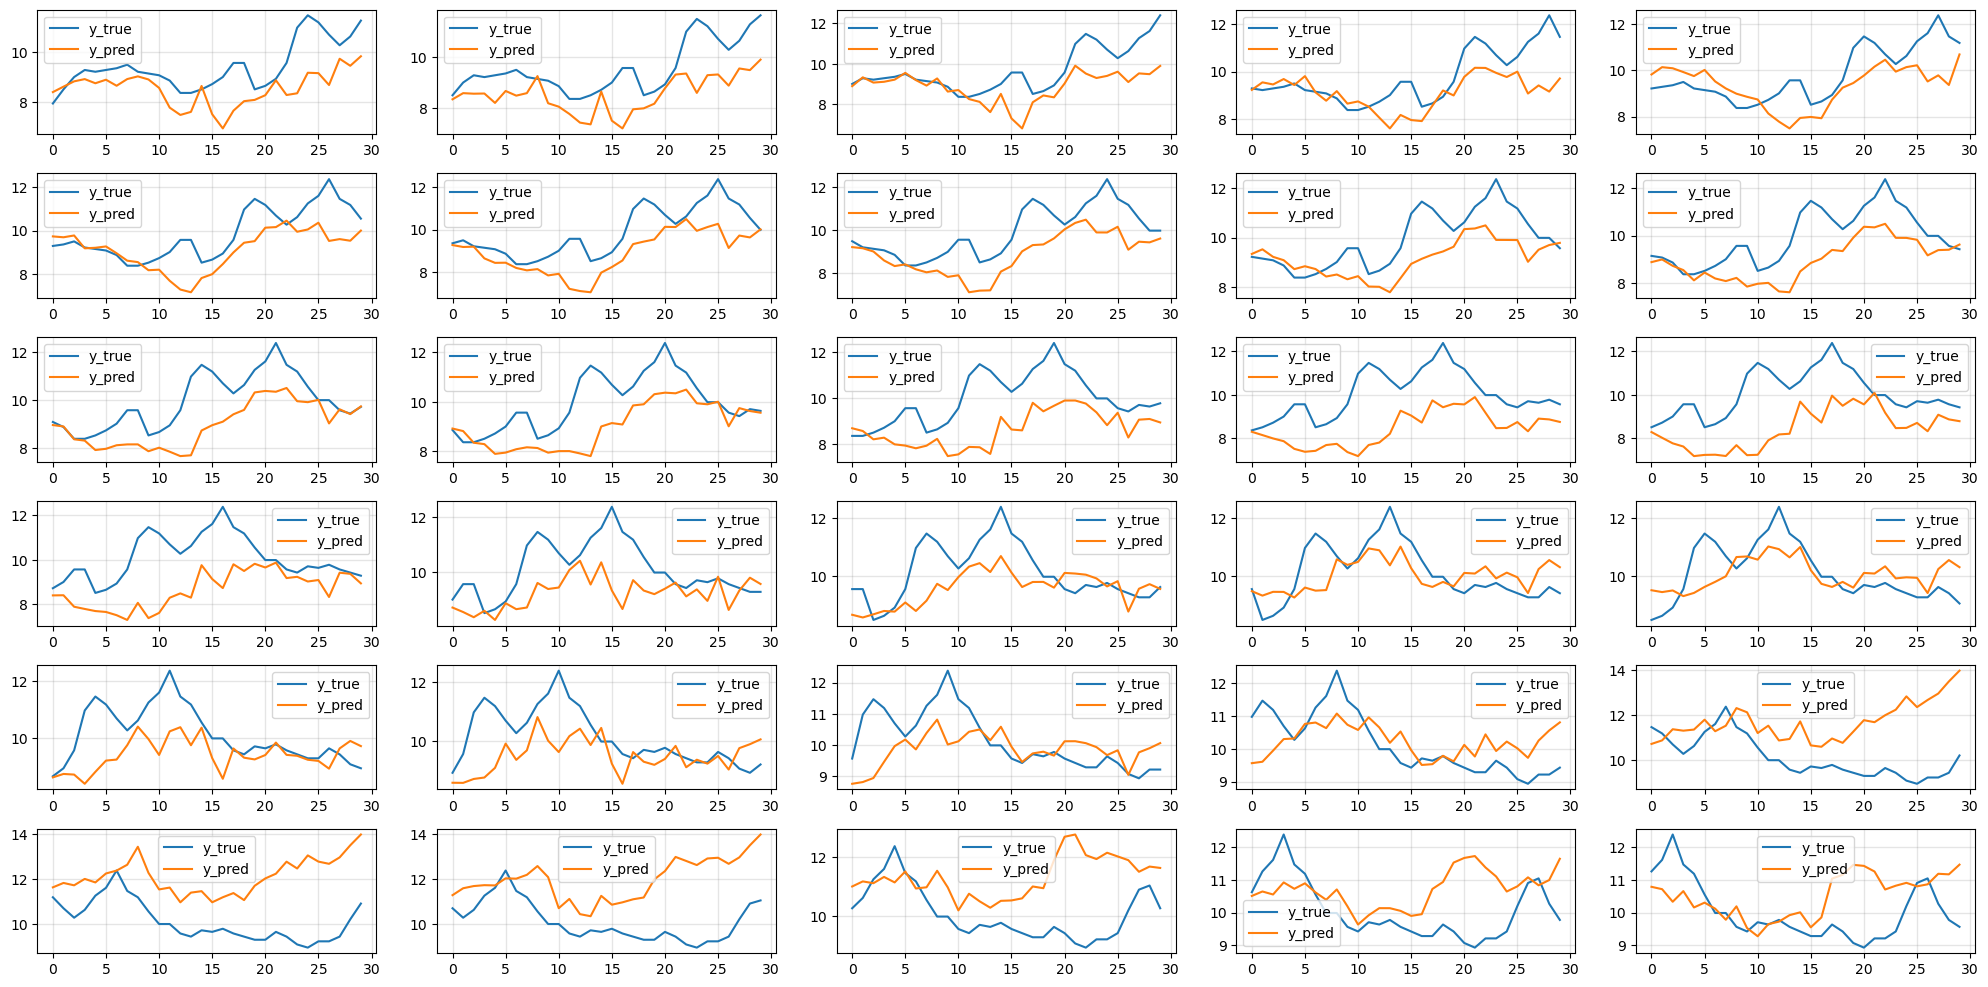

In [28]:
gbrt_processor = GBRTPreprocessing(128, 30, y_name, date_col='date', differential_n=0)
gbrt_processor.fit(data[['date', y_name]])
x_train, x_test, y_train, y_test = gbrt_processor.transform(data[['date', y_name]])

wide_gbrt = WideGBRT(model=LGBMRegressor(linear_tree=False))
wide_gbrt.fit(x_train, y_train, eval_set=([x_test, y_test]), early_stopping_rounds=10, verbose=0)
y_pred = wide_gbrt.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred)}")
a = plot2d(y_test, y_pred, figsize=(20, 10), eval_slices='[-30:]', labels=['y_true', 'y_pred'])